In [ ]:
import xml.etree.ElementTree as ET
from operator import itemgetter

import keras.models
import keras.layers
from keras.callbacks import History
from keras.utils.vis_utils import model_to_dot

import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG

import sananmuunnin as sm
from one_hot import *

plt.style.use('seaborn-darkgrid')

In [2]:
KOTUS_WORD_LIST = "./kotus/kotus-sanalista_v1.xml"
MODEL_PATH = "./sm-seq2seq.h5"

HIDDEN_SIZE = 80
BATCH_SIZE = 128
EPOCHS = 20

TRAIN_SIZE = 250000
VAL_SIZE = 50000

In [3]:
def read_kotus_words(filename, characters, max_len):
    def is_valid(word):
        return (
            all(char in characters for char in word) and
            len(word) < max_len / 2
        )

    return [
        s.text for s in ET.parse(filename).iterfind("st/s")
        if is_valid(s.text)
    ]

words = read_kotus_words(KOTUS_WORD_LIST, CHARACTERS, MAX_LEN)
words[:5]

['aakkonen', 'aakkostaa', 'aakkosto', 'aakkostus', 'aallokas']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                35840     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 80)            51520     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 31)            2511      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 31)            0         
Total params: 89,871
Trainable params: 89,871
Non-trainable params: 0
_________________________________________________________________


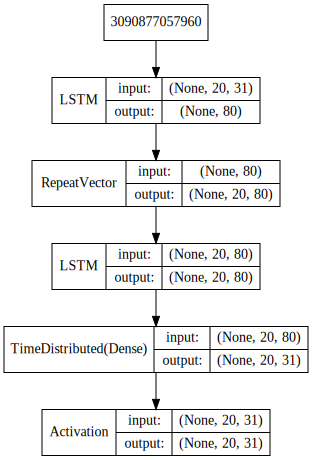

In [4]:
encoder = OneHot()

model = keras.models.Sequential(
    [
        keras.layers.LSTM(HIDDEN_SIZE, input_shape=(MAX_LEN, N_CHARACTERS)),
        keras.layers.RepeatVector(MAX_LEN),
        keras.layers.LSTM(HIDDEN_SIZE, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(N_CHARACTERS)),
        keras.layers.Activation("softmax"),
    ]
)

model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

model.summary()
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog="dot", format="svg"))

In [5]:
def generate_data(words, encoder, size):

    def _generate_data():
        word_indices = np.random.randint(0, len(words), (size, 2))
        for pair_indices in word_indices:
            input_words = itemgetter(*pair_indices)(words)
            output_words = sm.process(*input_words)
            yield (
                encoder.encode(" ".join(input_words)),
                encoder.encode(" ".join(output_words)),
            )

    x, y = zip(*_generate_data())
    return np.stack(x, axis=0), np.stack(y, axis=0)

x_train, y_train = generate_data(words, encoder, TRAIN_SIZE)
x_val, y_val = generate_data(words, encoder, VAL_SIZE)

x_train.shape, y_train.shape

((250000, 20, 31), (250000, 20, 31))

In [6]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[History()],
    verbose=2,
)

Train on 250000 samples, validate on 50000 samples
Epoch 1/20
 - 185s - loss: 1.9945 - acc: 0.3861 - val_loss: 1.6592 - val_acc: 0.4680
Epoch 2/20
 - 171s - loss: 1.4526 - acc: 0.5250 - val_loss: 1.2451 - val_acc: 0.5835
Epoch 3/20
 - 175s - loss: 1.1362 - acc: 0.6250 - val_loss: 1.0013 - val_acc: 0.6686
Epoch 4/20
 - 162s - loss: 0.8900 - acc: 0.7069 - val_loss: 0.7976 - val_acc: 0.7388
Epoch 5/20
 - 167s - loss: 0.7460 - acc: 0.7572 - val_loss: 0.6777 - val_acc: 0.7809
Epoch 6/20
 - 162s - loss: 0.5829 - acc: 0.8114 - val_loss: 0.5227 - val_acc: 0.8312
Epoch 7/20
 - 191s - loss: 0.4705 - acc: 0.8489 - val_loss: 0.6246 - val_acc: 0.8113
Epoch 8/20
 - 202s - loss: 0.5503 - acc: 0.8290 - val_loss: 0.3850 - val_acc: 0.8784
Epoch 9/20
 - 164s - loss: 0.3440 - acc: 0.8919 - val_loss: 0.3230 - val_acc: 0.8993
Epoch 10/20
 - 146s - loss: 0.2819 - acc: 0.9124 - val_loss: 0.2660 - val_acc: 0.9174
Epoch 11/20
 - 145s - loss: 0.2759 - acc: 0.9157 - val_loss: 0.3645 - val_acc: 0.8816
Epoch 12/20


In [7]:
model.save(MODEL_PATH)

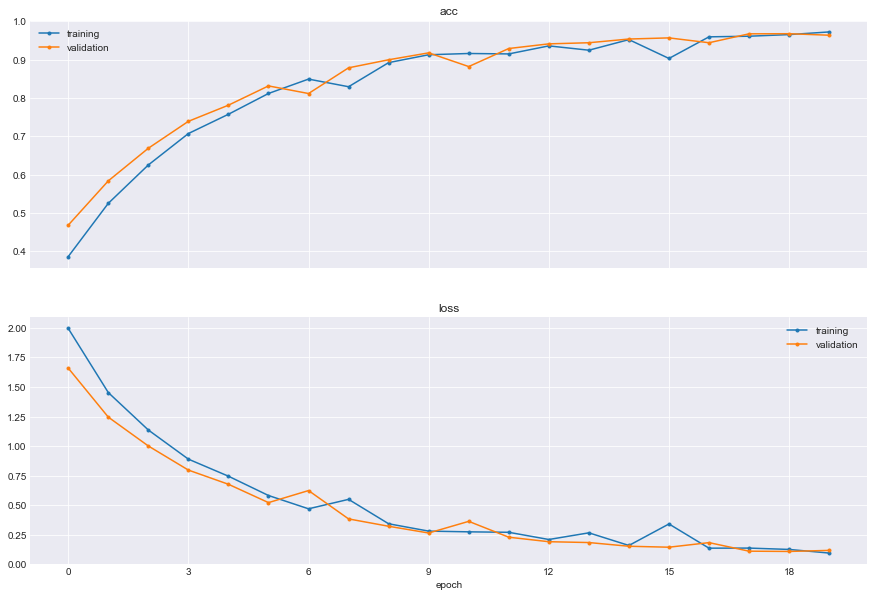

In [8]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

for ax, value in zip(axes, ("acc", "loss")):
    ax.plot(history.history[value], 'o-', ms=3, label="training")
    ax.plot(history.history[f"val_{value}"], 'o-', ms=3, label="validation")
    ax.set_title(value)
    ax.legend()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("epoch");

In [9]:
def predict(model, encoder, words):
    x = encoder.encode(words)[np.newaxis]
    y = model.predict(x)[0]
    return encoder.decode(y)

In [10]:
predict(model, encoder, "muistakaa hana")

'haistakaa muna'